# Explore data

## Load libraries

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import sys

# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# dataframe display settings
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


polars.config.Config

In [2]:
from airbus_ship_detection import configs
from airbus_ship_detection import processing
from airbus_ship_detection import visuals

## Load and process data

In [17]:
# load with polars
df_labels = pl.read_csv(configs.DIR_DATA / "train_ship_segmentations_v2.csv")

# add number of ships
df_labels = processing.process_labels(df_labels)

df_labels.head()

ImageId,EncodedPixels,n_ships,has_ship
str,str,u32,bool
"""00003e153.jpg""",null,0,false
"""0001124c7.jpg""",null,0,false
"""000155de5.jpg""","""264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 …",1,true
"""000194a2d.jpg""","""360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165…",5,true
"""000194a2d.jpg""","""51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 6105…",5,true


## Explore data

Text(0.5, 0.98, 'Distribution of ships in images')

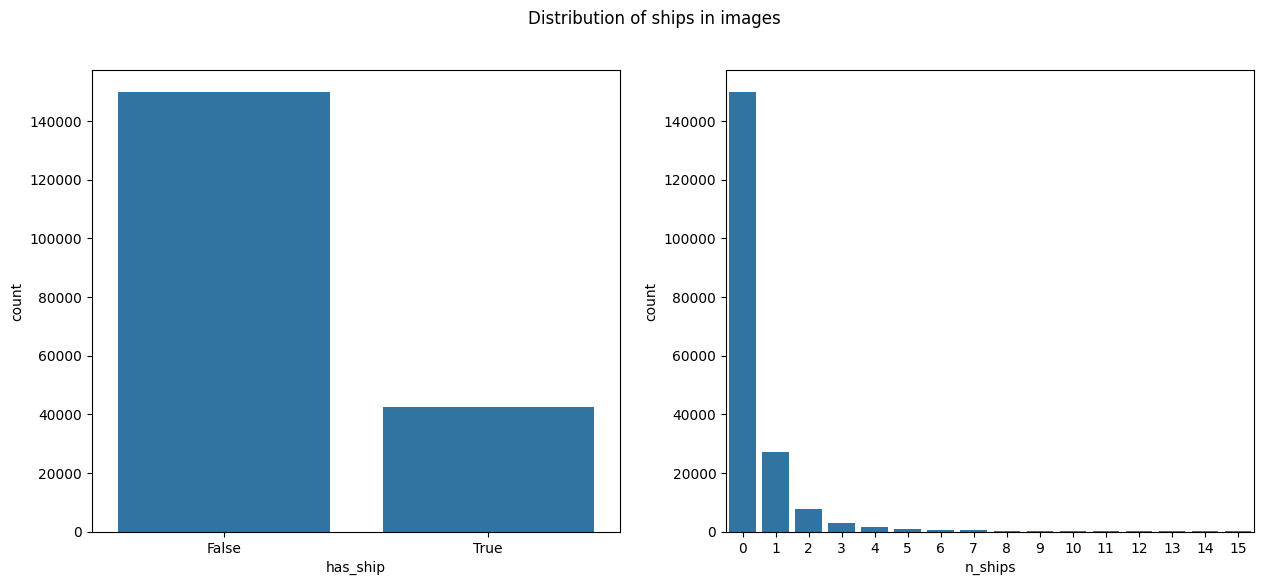

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
df_labels_unique = df_labels.unique(subset=['ImageId'])
sns.countplot(data=df_labels_unique, x='has_ship', ax=ax[0])
sns.countplot(data=df_labels_unique, x='n_ships', ax=ax[1])
fig.suptitle('Distribution of ships in images')


From this we can see a class imbalance in the dataset. Most images do not contain ships. For images that do contain ships, most contain only one ship, but there are some images with many ships up to 15 ships in one image.

Path: /Users/dknoors/data/airbus-ship-detection/train_v2/2bec10dd6.jpg, Image name: 2bec10dd6.jpg, size: (768, 768), mode: RGB
Plotted 2bec10dd6.jpg with 1 ships.
Path: /Users/dknoors/data/airbus-ship-detection/train_v2/83ef2e8fd.jpg, Image name: 83ef2e8fd.jpg, size: (768, 768), mode: RGB
Plotted 83ef2e8fd.jpg with 1 ships.
Path: /Users/dknoors/data/airbus-ship-detection/train_v2/d89018687.jpg, Image name: d89018687.jpg, size: (768, 768), mode: RGB
Plotted d89018687.jpg with 1 ships.
Path: /Users/dknoors/data/airbus-ship-detection/train_v2/e1dbf8702.jpg, Image name: e1dbf8702.jpg, size: (768, 768), mode: RGB
Plotted e1dbf8702.jpg with 1 ships.
Path: /Users/dknoors/data/airbus-ship-detection/train_v2/4ae0e0dbf.jpg, Image name: 4ae0e0dbf.jpg, size: (768, 768), mode: RGB
Plotted 4ae0e0dbf.jpg with 1 ships.


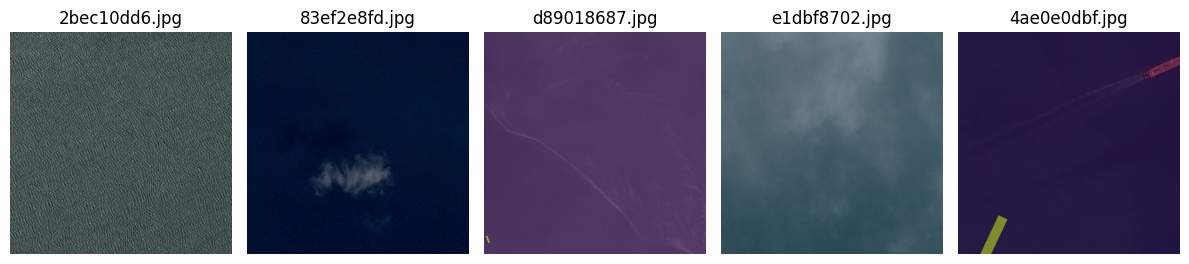

In [ ]:
def overlay_mask_on_ax(mask, ax, alpha=0.5):
    """Overlay a binary mask on a matplotlib axis."""
    # only overlay if mask has any positive values keep rest transparent
    if mask.sum() > 0:
        ax.imshow(mask, alpha=alpha)



# open random images
n_figs = 5
fig, axs = plt.subplots(1, n_figs, figsize=(12, 6))
if n_figs == 1:
    axs = [axs]
for ax in axs:
    visuals.plot_random_image(configs.DIR_DATA_TRAIN_IMG, ax=ax)
    # overlay encoded pixels
    img_name = ax.get_title()
    encoded_pixels = df_labels.filter(pl.col("ImageId") == img_name).select("EncodedPixels").to_series().to_list()
    for ep in encoded_pixels:
        if ep is not None:
            mask = processing.rle_decode(ep, (768, 768))
            overlay_mask_on_ax(mask, ax=ax)

    print(f"Plotted {img_name} with {len(encoded_pixels)} ships.")
plt.tight_layout()
plt.show()

In [73]:
encoded_pixels

['29723 9 30491 17 31259 17 32027 17 32795 17 33563 17 34330 18 35098 17 35866 17 36634 17 37402 17 38170 17 38938 17 39706 17 40474 17 41242 17 42010 17 42777 18 43545 17 44313 17 45081 17 45849 17 46617 17 47385 17 48153 17 48921 17 49689 17 50457 17 51224 18 51992 17 52760 17 53528 17 54296 17 55064 17 55832 17 56600 17 57368 17 58136 17 58904 17 59671 18 60439 17 61207 17 61975 17 62743 17 63511 17 64279 17 65047 17 65815 17 66583 17 67351 17 68118 18 68886 17 69654 17 70422 17 71190 17 71958 17 72726 17 73494 17 74262 17 75030 17 75798 17 76565 18 77333 17 78101 17 78869 17 79637 17 80405 17 81173 17 81941 17 82709 17 83477 17 84245 17 85012 18 85780 17 86548 17 87316 17 88084 17 88852 17 89620 17 90388 17 91156 17 91924 17 92692 17 93459 18 94227 17 94995 17 95763 17 96531 17 97299 17 98076 8']

In [74]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(768, 768), dtype=uint8)